## Configure osmnx and import things

In [1]:
import osmnx as ox
ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('nerails_simplified.graphml')
# graph = graph.to_undirected()

In [2]:
import numpy as np
import networkx as nx
import scipy.sparse
import scipy.sparse.csgraph
import pandas as pd

## General info

In [24]:
graph = graph.to_undirected()
pandasel = nx.to_pandas_edgelist(graph)
print(pandasel.length.describe())

count    7162.000000
mean       14.689404
std        17.510375
min         0.591086
25%         5.513821
50%        10.120634
75%        17.364376
max       202.114129
Name: length, dtype: float64


In [25]:
print(nx.info(graph))
graph = graph.to_directed() # Some analyzing tasks hate if the graph is undirected.

Name: unnamed
Type: MultiGraph
Number of nodes: 5014
Number of edges: 7162
Average degree:   2.8568


In [5]:
ox.basic_stats(graph)

{'n': 5014,
 'm': 14324,
 'k_avg': 5.7136019146390105,
 'intersection_count': 4813,
 'streets_per_node_avg': 2.8568009573195052,
 'streets_per_node_counts': {0: 0,
  1: 201,
  2: 2649,
  3: 1156,
  4: 492,
  5: 225,
  6: 101,
  7: 73,
  8: 37,
  9: 32,
  10: 14,
  11: 7,
  12: 14,
  13: 7,
  14: 3,
  15: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.04008775428799362,
  2: 0.5283207020343039,
  3: 0.23055444754686877,
  4: 0.09812524930195453,
  5: 0.04487435181491823,
  6: 0.02014359792580774,
  7: 0.014559234144395692,
  8: 0.007379337854008776,
  9: 0.006382130035899481,
  10: 0.002792181890706023,
  11: 0.0013960909453530116,
  12: 0.002792181890706023,
  13: 0.0013960909453530116,
  14: 0.0005983246908655763,
  15: 0.0005983246908655763},
 'edge_length_total': 210411.0277007943,
 'edge_length_avg': 14.689404335436631,
 'street_length_total': 105205.51385039769,
 'street_length_avg': 14.689404335436707,
 'street_segments_count': 7162,
 'node_density_km': None,
 'intersection_

In [6]:
# Takes a fucking lifetime
# extended_graph_stats = ox.extended_stats(graph, connectivity=True, anc=True, ecc=True, bc=True, cc=True)
extended_graph_stats = ox.extended_stats(graph, ecc=True, bc=True, cc=True)
# ^even this takes about 10 minutes

In [15]:
print(extended_graph_stats.keys())

dict_keys(['avg_neighbor_degree', 'avg_neighbor_degree_avg', 'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg', 'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient', 'clustering_coefficient_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node', 'pagerank_max', 'pagerank_min_node', 'pagerank_min', 'eccentricity', 'diameter', 'radius', 'center', 'periphery', 'closeness_centrality', 'closeness_centrality_avg', 'betweenness_centrality', 'betweenness_centrality_avg'])


0.4204108880825091


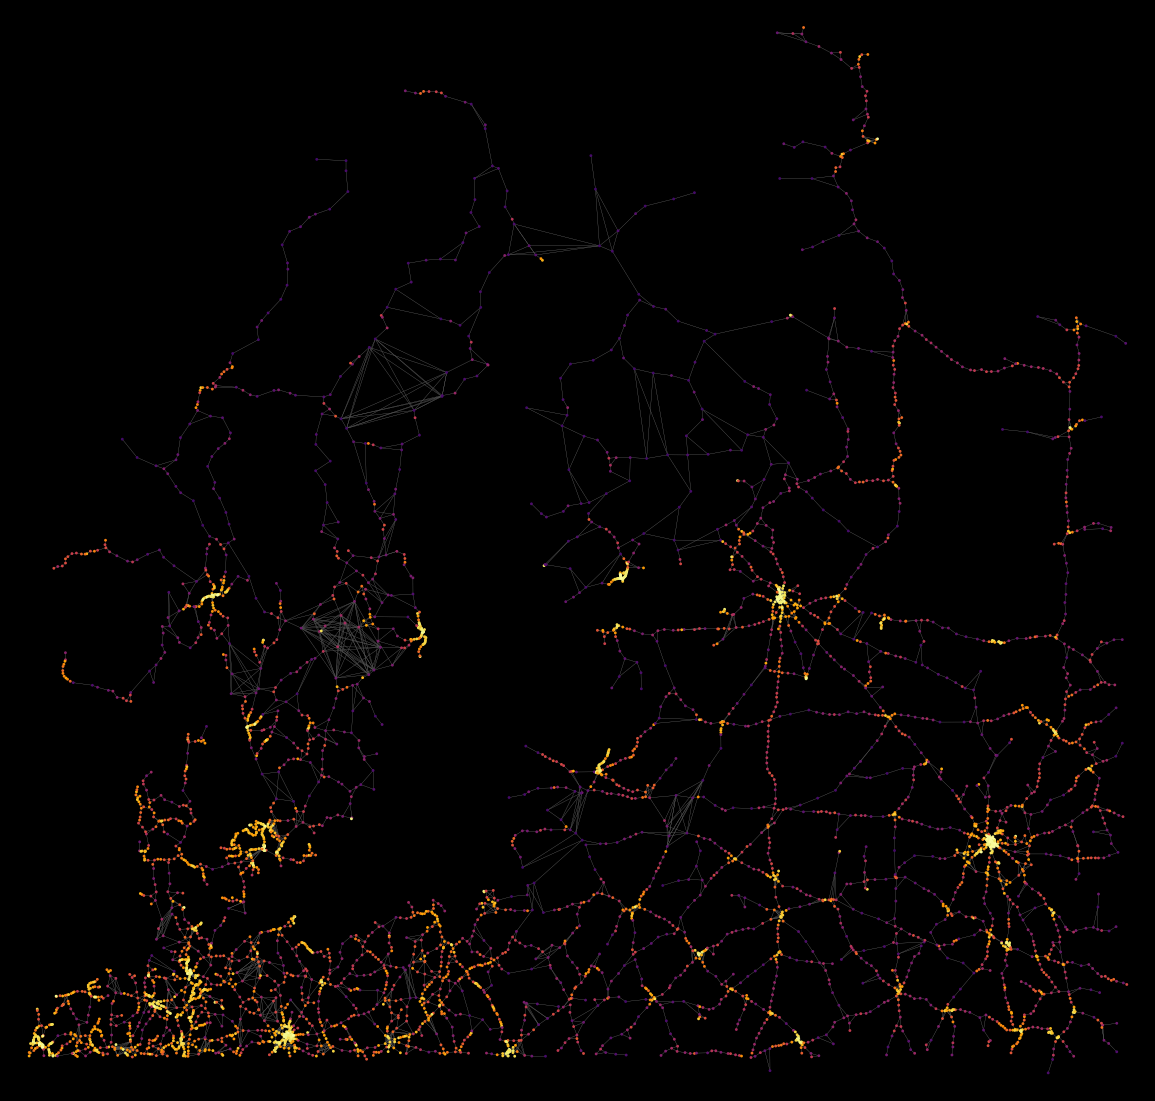

In [30]:
print(extended_graph_stats['avg_weighted_neighbor_degree_avg'])
df = pd.DataFrame(data=pd.Series(extended_graph_stats['avg_weighted_neighbor_degree']).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(graph, bgcolor='k', node_size=8, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.25, edge_alpha=1, fig_height=20)

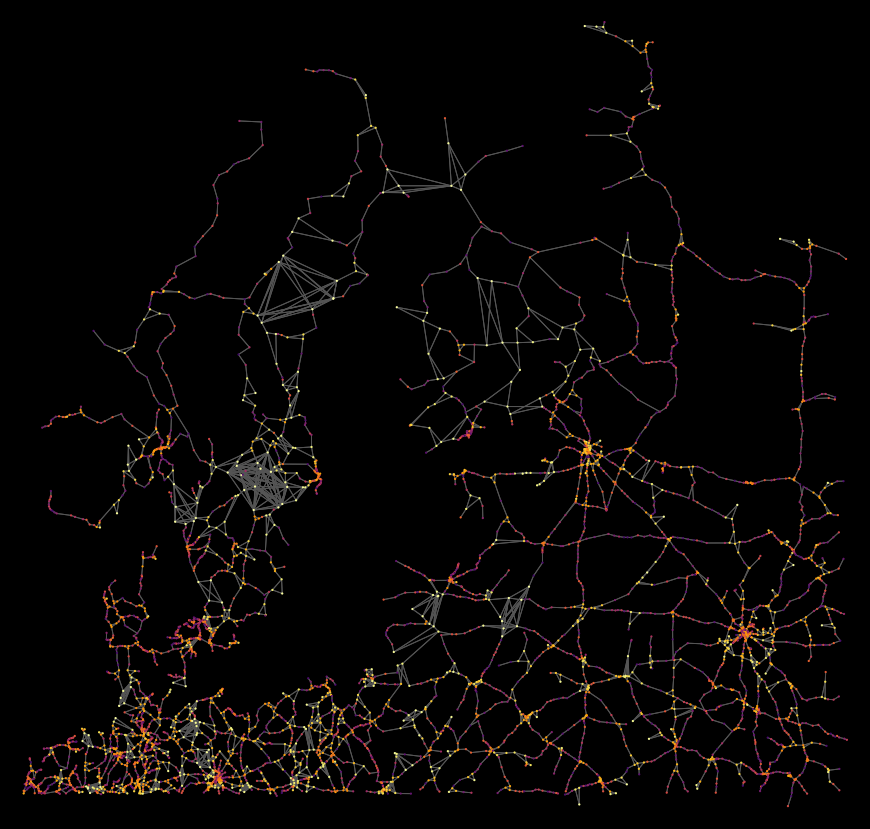

In [16]:
df = pd.DataFrame(data=pd.Series(extended_graph_stats['clustering_coefficient_weighted']).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(graph, bgcolor='k', node_size=5, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1, fig_height=15)

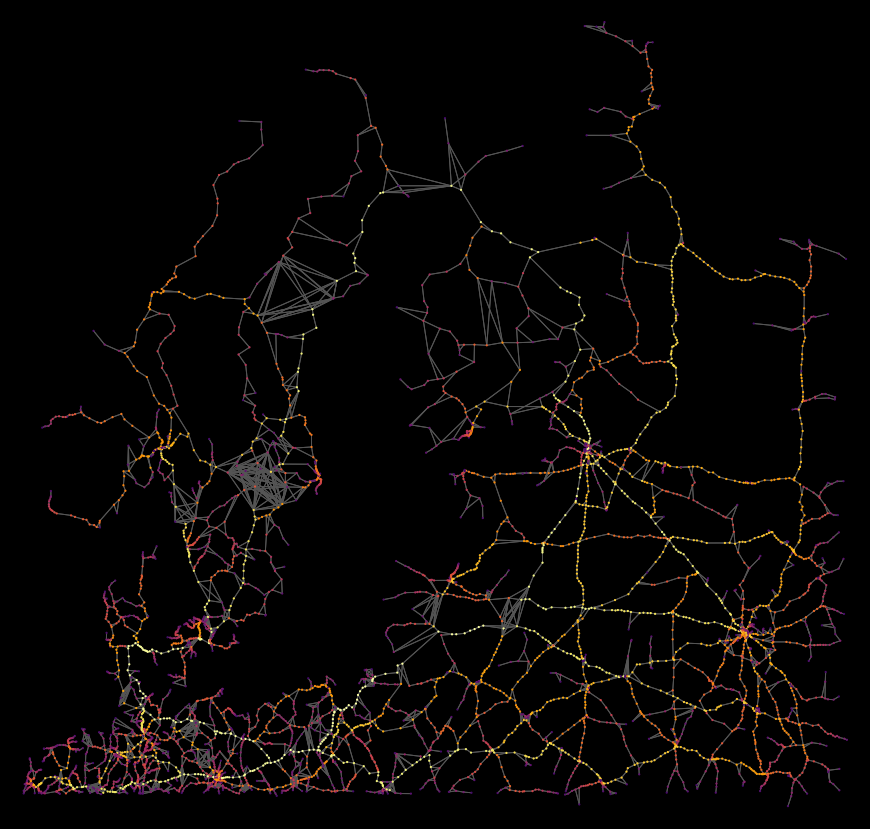

In [17]:
df = pd.DataFrame(data=pd.Series(extended_graph_stats['betweenness_centrality']).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(graph, bgcolor='k', node_size=5, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1, fig_height=15)

## Node centrality

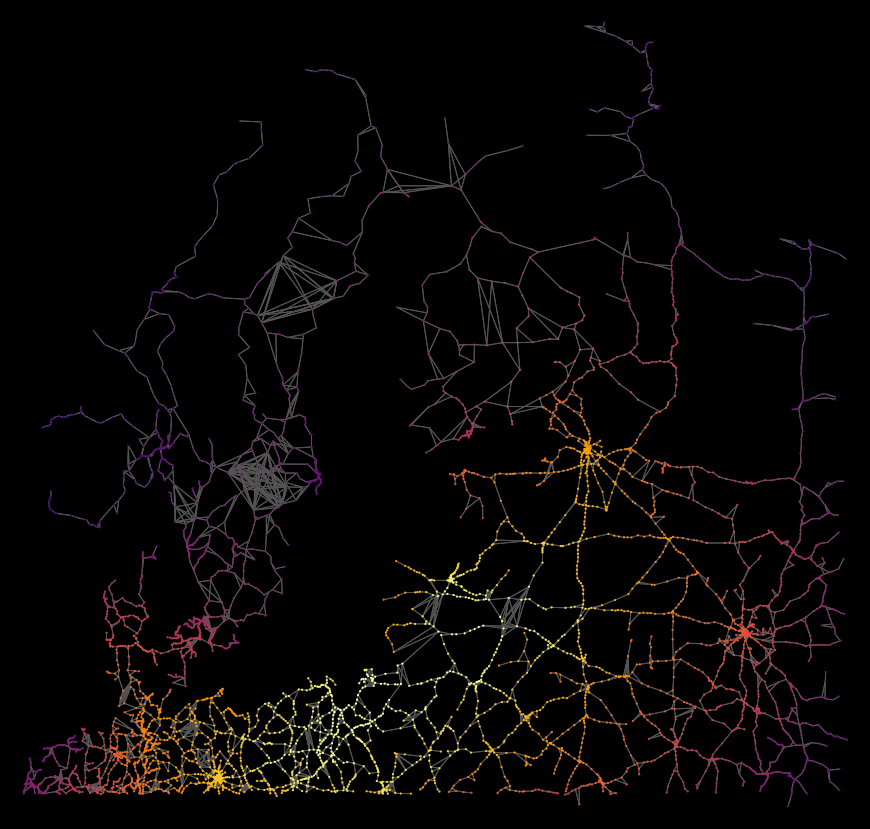

In [7]:
#node_centrality = nx.closeness_centrality(G)
# networkx implementation is superrrr slow, source of this code is from
# https://medium.com/@pasdan/closeness-centrality-via-networkx-is-taking-too-long-1a58e648f5ce

G = graph
G = G.to_undirected()

A = nx.adjacency_matrix(graph, nodelist=None, weight='length').tolil()
D = scipy.sparse.csgraph.floyd_warshall(A, directed=False, unweighted=False)

n = D.shape[0]
closeness_centrality = {}
for r in range(0, n):
    
    cc = 0.0
    
    possible_paths = list(enumerate(D[r, :]))
    shortest_paths = dict(filter( \
        lambda x: not x[1] == np.inf, possible_paths))
    
    total = sum(shortest_paths.values())
    n_shortest_paths = len(shortest_paths) - 1.0
    if total > 0.0 and n > 1:
        s = n_shortest_paths / (n - 1)
        cc = (n_shortest_paths / total) * s
    closeness_centrality[list(graph.nodes)[r]] = cc
    
node_centrality = closeness_centrality

# https://github.com/gboeing/osmnx-examples/blob/master/notebooks/08-example-line-graph.ipynb

df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(graph, bgcolor='k', node_size=5, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1, fig_height=15)